In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from numba import jit
import itertools

In [3]:
def arm_points(lengths, angles, x0 = 0, y0 = 0):
    x = x0
    y = y0

    last_alpha = angles[0]

    x += lengths[0] * np.cos(last_alpha)
    y += lengths[0] * np.sin(last_alpha)


    res = [(x0, y0), (x,y)]

    for i in range(1, len(angles)):
        length = lengths[i]
        angle = angles[i]

        alpha = angle - np.pi + last_alpha

        x += length * np.cos(alpha)
        y += length * np.sin(alpha)

        last_alpha = alpha
        res.append((x,y))

    return res

def arm_end(lengths, angles, x0 = 0, y0 = 0):
    return arm_points(lengths, angles, x0, y0)[-1]

def distance(a, b):
    return np.sqrt((a[0]-b[0])**2 + (a[1] - b[1])**2)


def degrees_to_radians(degrees):
    return list(map(lambda x: x/180 * np.pi, degrees))


lengths = [1, 1, 5]
angles = [45, 180, 225]

# arm_end(lengths, degrees_to_radians(angles))
arm_points(lengths, degrees_to_radians(angles))

[(0, 0),
 (0.7071067811865476, 0.7071067811865475),
 (1.4142135623730951, 1.414213562373095),
 (1.4142135623730954, 6.414213562373095)]

In [4]:
class InverseKinematics:
    def __init__(self, lengths, limits, target, start=(0,0)) -> None:
        self.lengths = lengths
        self.limits = limits
        if limits == None:
            self.limits = [(0, 2*np.pi)] * len(lengths)
        self.target = target
        self.start = start

    def objective_function(self, solution):
        return -distance(arm_end(self.lengths, solution), self.target)

        
class EvolutionParams:
    def __init__(self, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0) -> None:
        self.populations_size = population_size
        self.number_of_iterations = number_of_iterations
        self.number_of_offspring = number_of_offspring
        self.number_of_parents = number_of_parents
        self.sigma = sigma
        self.tau = tau
        self.tau_0 = tau_0

    # def init_population()
    

In [5]:
def random_population(population_size, limits):
    def random_individual():
        return [np.random.rand() * (lim[1] - lim[0]) + lim[0] for lim in limits]

    return np.array([random_individual() for _ in range(population_size)])


def mutation(P, S, limits, tau, tau0):
    N = len(P)
    n = len(P[0])

    def fix(x, limits, sigma):
        res = x + np.random.randn() * sigma
        while res < limits[0] or res >= limits[1]:
            res = x + np.random.randn() * sigma

        return res

    def mutate_ind(i):
        epsilon0 = np.random.randn() * tau0
        epsilons = np.random.randn(n) * tau
        new_S = S[i] * np.exp(epsilons + epsilon0)
        epsilons = np.random.randn(n) * new_S
        new_P = (P[i] + epsilons) % (2*np.pi)

        return new_P, new_S

    for i in range(N):
        Pi, Si = mutate_ind(i)

        for j in range(len(Pi)):
            lim = limits[j]
            Pi[j] = (Pi[j] % (lim[1] - lim[0])) + lim[0]
            # if Pi[j] < limits[j][0]:
            #     Pi[j] = np.random.rand() * (lim[1] - lim[0]) + lim[0]
            # elif Pi[j] > limits[j][1]:
            #     Pi[j] = np.random.rand() * (lim[1] - lim[0]) + lim[0]

        P[i], S[i] = Pi, Si


def parent_selection(P, scores, number_of_offspring, number_of_parents):
    population_size = len(P)

    fitness_values = scores - scores.min()
    if fitness_values.sum() > 0:
        fitness_values = fitness_values / fitness_values.sum()
    else:
        fitness_values = np.ones(population_size) / population_size

    parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

    return parent_indices

def population_evaluation(population, problem):
    scores = np.zeros(len(population))
    for i in range(len(scores)):
        scores[i] = problem.objective_function(population[i])
    return scores


def crossover(number_of_offspring, chromosome_length, current_population_solutions, current_population_sigmas, parent_indices):
    children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
    children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
    for i in range(number_of_offspring):
        children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
        children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

    return children_population_solutions, children_population_sigmas



def ES(problem: InverseKinematics, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, plus=True):
    P = random_population(population_size, problem.limits)
    S = sigma * np.ones((population_size, len(problem.limits)))

    scores = population_evaluation(P, problem)

    history = []
    history.append(P)
    
    history_scores = []
    history_scores.append(scores)
    
    for _ in tqdm(range(number_of_iterations)):
        parent_indices = parent_selection(P, scores, number_of_offspring, number_of_parents)
        P_c, S_c = crossover(number_of_offspring, len(problem.limits), P, S, parent_indices)

        mutation(P_c, S_c, problem.limits, tau, tau_0)

        scores_c = population_evaluation(P_c, problem)

        # Replacement
        if plus: # ES(mu + lambda)
            P_all = np.vstack((P, P_c))
            S_all = np.vstack((S, S_c))
            scores_all = np.hstack((scores, scores_c))
        else: # ES(mu, lambda)
            P_all = P_c
            S_all = S_c
            scores_all = scores_c

        sorted_scores_ind = np.argsort(scores_all)[::-1]

        P = P_all[sorted_scores_ind[:population_size]]
        S = S_all[sorted_scores_ind[:population_size]]
        scores = scores_all[sorted_scores_ind[:population_size]]
        # print(scores.min(), scores.mean(), scores.max())
        # stats.append((scores.min(), scores.mean(), scores.max()))
        history.append(P)
        history_scores.append(scores)

    return np.array(history), np.array(history_scores)

In [6]:
from matplotlib.lines import Line2D

def plot_min_max_mean(populations_objective_values):
    line_width = 1.5
    ea_means = np.mean(populations_objective_values, axis=1)
    ea_maxs = np.max(populations_objective_values, axis=1)
    ea_mins = np.min(populations_objective_values, axis=1)

    plt.figure(figsize=[12, 7])

    plt.axis(True)
    plt.grid(True)

    plt.plot(ea_means, linewidth=1.5, label="mean")
    plt.plot(ea_mins, linewidth=1.5, label="min")
    plt.plot(ea_maxs, linewidth=1.5, label="max")
    plt.legend()
    plt.show()


def best_solution(history, history_score):
    index = np.unravel_index(np.argmax(history_score), history_score.shape)
    return history[index], history_score[index]

def draw_solution(problem: InverseKinematics, angles):
    points = arm_points(problem.lengths, angles)
    # print(points)

    plt.figure(figsize=(12,8))
    fig, ax = plt.subplots(figsize=(12,8))
    plt.gca().set_aspect('equal', adjustable='box')

    for i in range(1, len(points)):
        x_values = [points[i-1][0], points[i][0]]
        y_values = [points[i-1][1], points[i][1]]

        plt.plot(x_values, y_values, linewidth=2)

    plt.scatter(x=[problem.start[0], problem.target[0]], y=[problem.start[1], problem.target[1]], color=['green', 'red'])
    plt.show()

def to_degrees(angles):
    return [ang * 180 / np.pi for ang in angles]

100%|██████████| 80/80 [00:00<00:00, 155.66it/s]


best solution: [0.68577846 3.43296652 2.37870283 3.71099436 2.92190745 3.76135072
 1.85216511 3.97118763 3.63699818 2.80102845]
distance: 6.041027368207596e-05


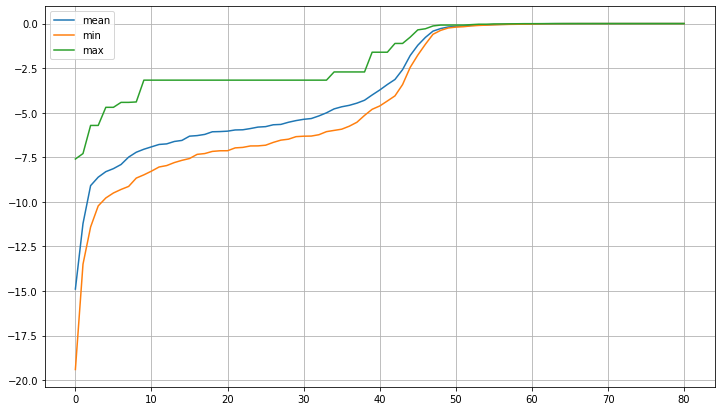

<Figure size 864x576 with 0 Axes>

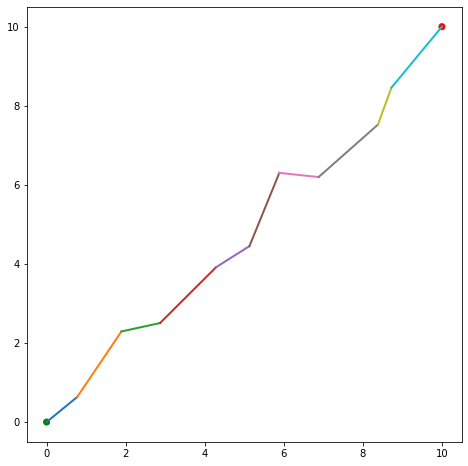

In [7]:
problem = InverseKinematics([1,2] * 5, None, (10, 10))

N = 50
history, history_score = ES(
    problem = problem,
    population_size=N, number_of_iterations=80, number_of_offspring=2*N, number_of_parents=2,
    sigma=1, tau=2/np.sqrt(2), tau_0=2/np.sqrt(2*np.sqrt(2)))



best, best_score = best_solution(history, history_score)

print(f"best solution: {best}\ndistance: {-best_score}")

plot_min_max_mean(history_score)

draw_solution(problem, best)

100%|██████████| 50/50 [00:00<00:00, 253.05it/s]


best solution: [90.55176563741091, 89.49584689137023, 269.31949326874246]
distance: 0.001589772300504677


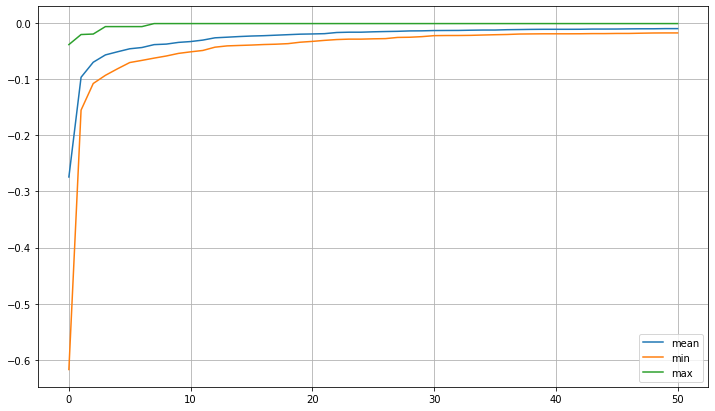

[(0, 0), (-0.009629978224258894, 0.9999536306846435), (0.9903696764990898, 1.000784625981434), (1.001415539517122, 2.0007236185755755)]


<Figure size 864x576 with 0 Axes>

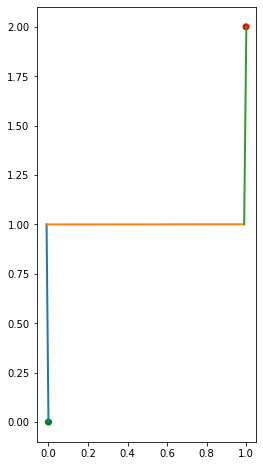

100%|██████████| 100/100 [00:01<00:00, 64.85it/s]


<Figure size 864x576 with 0 Axes>

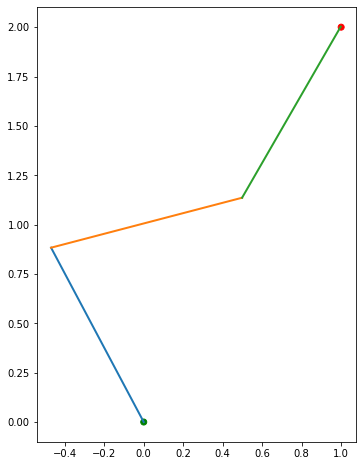

In [8]:
limits = [(0.45*np.pi, 0.55* np.pi), (0.49 * np.pi, 0.51 * np.pi), (1.4 * np.pi, 1.51*np.pi)]

problem = InverseKinematics([1,1,1], limits, (1, 2))

N = 50
history, history_score = ES(
    problem = problem,
    population_size=N, number_of_iterations=50, number_of_offspring=2*N, number_of_parents=2,
    sigma=1, tau=1/np.sqrt(2), tau_0=1/np.sqrt(2*np.sqrt(2)), plus=True)



best, best_score = best_solution(history, history_score)

print(f"best solution: {to_degrees(best)}\ndistance: {-best_score}")

plot_min_max_mean(history_score)

print(arm_points(problem.lengths, best))

draw_solution(problem, best)


problem = InverseKinematics([1,1,1], None, (1, 2))

N = 200
history, history_score = ES(
    problem = problem,
    population_size=N, number_of_iterations=100, number_of_offspring=2*N, number_of_parents=2,
    sigma=1, tau=0.2/np.sqrt(2), tau_0=0.2/np.sqrt(2*np.sqrt(2)), plus=True)

best, best_score = best_solution(history, history_score)

draw_solution(problem, best)

100%|██████████| 100/100 [00:01<00:00, 85.63it/s]


best solution: [91.94283040796205, 82.70866888461427, 254.32433370782712, 278.20140463664825, 275.1513192365976, 261.52292341043704, 254.31398417109878, 285.8758480229407, 259.89675622973226]
distance: 2.220446049250313e-16


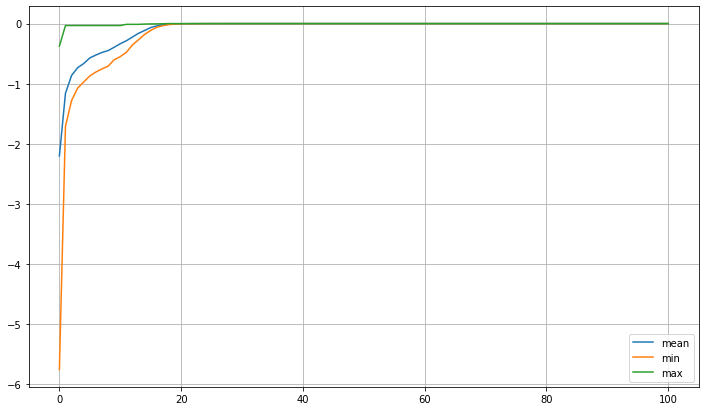

<Figure size 864x576 with 0 Axes>

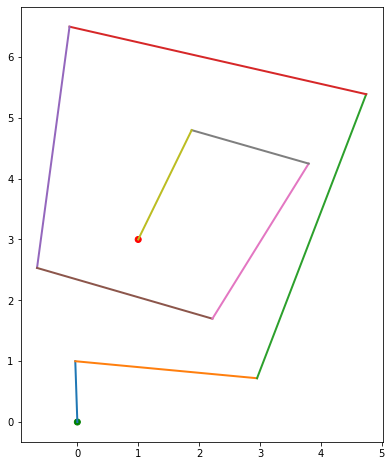

In [29]:
limits = ([(0.4*np.pi, 0.6*np.pi)] * 2) + ([(1.4 * np.pi, 1.6 * np.pi)] * 7)
problem = InverseKinematics([1, 3, 5, 5, 4, 3, 3, 2, 2], limits, (1, 3))

N = 100
history, history_score = ES(
    problem = problem,
    population_size=N, number_of_iterations=100, number_of_offspring=2*N, number_of_parents=1,
    sigma=1, tau=1/np.sqrt(2), tau_0=1/np.sqrt(2*np.sqrt(2)), plus=True)



best, best_score = best_solution(history, history_score)

print(f"best solution: {to_degrees(best)}\ndistance: {-best_score}")

plot_min_max_mean(history_score)
draw_solution(problem, best)